In [6]:
import numpy as np
import scanpy as sc
import ToppCellPy as tp
import warnings
warnings.filterwarnings("ignore")

### 1. load data

This PBMC dataset is from [Wilk et al.2020](https://www.nature.com/articles/s41591-020-0944-y), which includes two conditions (COVID-19 vs. healthy) and 20 cell types. It can be downloaded from [here](https://cellxgene.cziscience.com/collections/a72afd53-ab92-4511-88da-252fb0e26b9a).

In [2]:
output_dir = "/Users/jinmr2/Dropbox/Code/data/toppcell_test/" # define output folder
adata = sc.read("/Users/jinmr2/Dropbox/Code/data/COVID-19_data_normalized_Blish.h5ad")

In [3]:
adata

AnnData object with n_obs × n_vars = 44721 × 26361
    obs: 'Admission', 'ClusterID', 'DPS', 'DTF', 'Donor_full', 'HLA1', 'IFN1', 'Sex', 'Status', 'Ventilated', 'cell_type_coarse', 'cell_type_fine', 'nCount_RNA', 'nCount_SCT', 'nFeature_RNA', 'nFeature_SCT', 'percent_mt', 'percent_rpl', 'percent_rps', 'percent_rrna', 'seurat_clusters', 'singler'
    var: 'Selected', 'sct_detection_rate', 'sct_gmean', 'sct_residual_mean', 'sct_residual_variance', 'sct_variable', 'sct_variance'
    uns: 'assay', 'authors', 'disease', 'log1p', 'organism', 'preprint', 'short_name', 'tissue'
    obsm: 'X_pca', 'X_umap'
    varm: 'pca_feature_loadings'

In [4]:
adata.obs.head()

,Admission,ClusterID,DPS,DTF,Donor_full,HLA1,IFN1,Sex,Status,Ventilated,...,nCount_RNA,nCount_SCT,nFeature_RNA,nFeature_SCT,percent_mt,percent_rpl,percent_rps,percent_rrna,seurat_clusters,singler
covid_555_1.1,ICU,13,9,9,C1 A,-0.026053,0.015625,M,COVID,NonVent,...,1222.0,1682.0,125,126,1.309329,0.245499,0.081833,46.644844,12,Erythroblast
covid_555_1.2,ICU,10,9,9,C1 A,0.023525,-0.000322,M,COVID,NonVent,...,1099.0,1700.0,160,160,13.102820,0.363967,0.363967,58.780708,9,B_cell
covid_555_1.3,ICU,19,9,9,C1 A,-0.044271,0.086385,M,COVID,NonVent,...,1055.0,1661.0,212,213,2.938389,0.947867,0.663507,55.829384,18,B_cell
covid_555_1.7,ICU,10,9,9,C1 A,-0.038040,0.022590,M,COVID,NonVent,...,2411.0,1971.0,312,312,10.908337,0.165906,0.041477,67.399422,9,B_cell
covid_555_1.8,ICU,22,9,9,C1 A,-0.043605,0.010739,M,COVID,NonVent,...,2276.0,1948.0,336,336,11.203866,0.307557,0.263620,67.355011,21,B_cell


In this case, we select two cell annotations, including COVID-19 Status ("Status") and cell type ("cell_type_fine") as metadata for ToppCell gene modules.

### 2. create shred object

Create a shred object with anndata and shred plan. 
Usually we use normalized data (e.g. log2(TPM+1)) for following differential expression analysis and visualization. There're two major components in ToppCell analysis, including:
- shred plan: the user-defined way for differential expression analysis and gene module generation. In this package, users can define a global level-wise comparison, like "cell_type_fine", which means gene module for each cell type; Additionally, a more complicated plan can be defined in a hierarchical way as well, like "Status+cell_type_fine|Status" (avoid blanks in between), which means the gene module for one cell type in a specific status versus all other cell types in this status.
- bin_group: the way to generate pseudo-bulk bins for single-cell data in the heatmap visualization.

More details can be found in ToppCell [tutorial](https://toppcell.cchmc.org/biosystems/go/docs/tutorial.md).

In [8]:
# create shred object
shred = tp.Shred(adata = adata,
                shred_plan = ["Status", "cell_type_fine", "Status+cell_type_fine|Status"],
                bin_group = ["Status", "cell_type_fine"],
                order_bins = None,
                order_modules = None,
                method = "wilcoxon",
                output_dir = output_dir)

In [9]:
# conduct differential expression based on the shred plan
shred.do_shredplan()

... storing 'bin_group' as categorical
... storing 'bin_id' as categorical
... storing 'bin_group' as categorical
... storing 'bin_id' as categorical
... storing 'bin_group' as categorical
... storing 'bin_id' as categorical
... storing 'target_value' as categorical
... storing 'bin_group' as categorical
... storing 'bin_id' as categorical
... storing 'target_value' as categorical


### 3. generate heatmap

Create a heatmap that contains all gene modules from the shred plan.

In [10]:
# create a heatmap view using top differential expressed genes in each gene module (default = 200)
shred.create_heatmap_matrix()

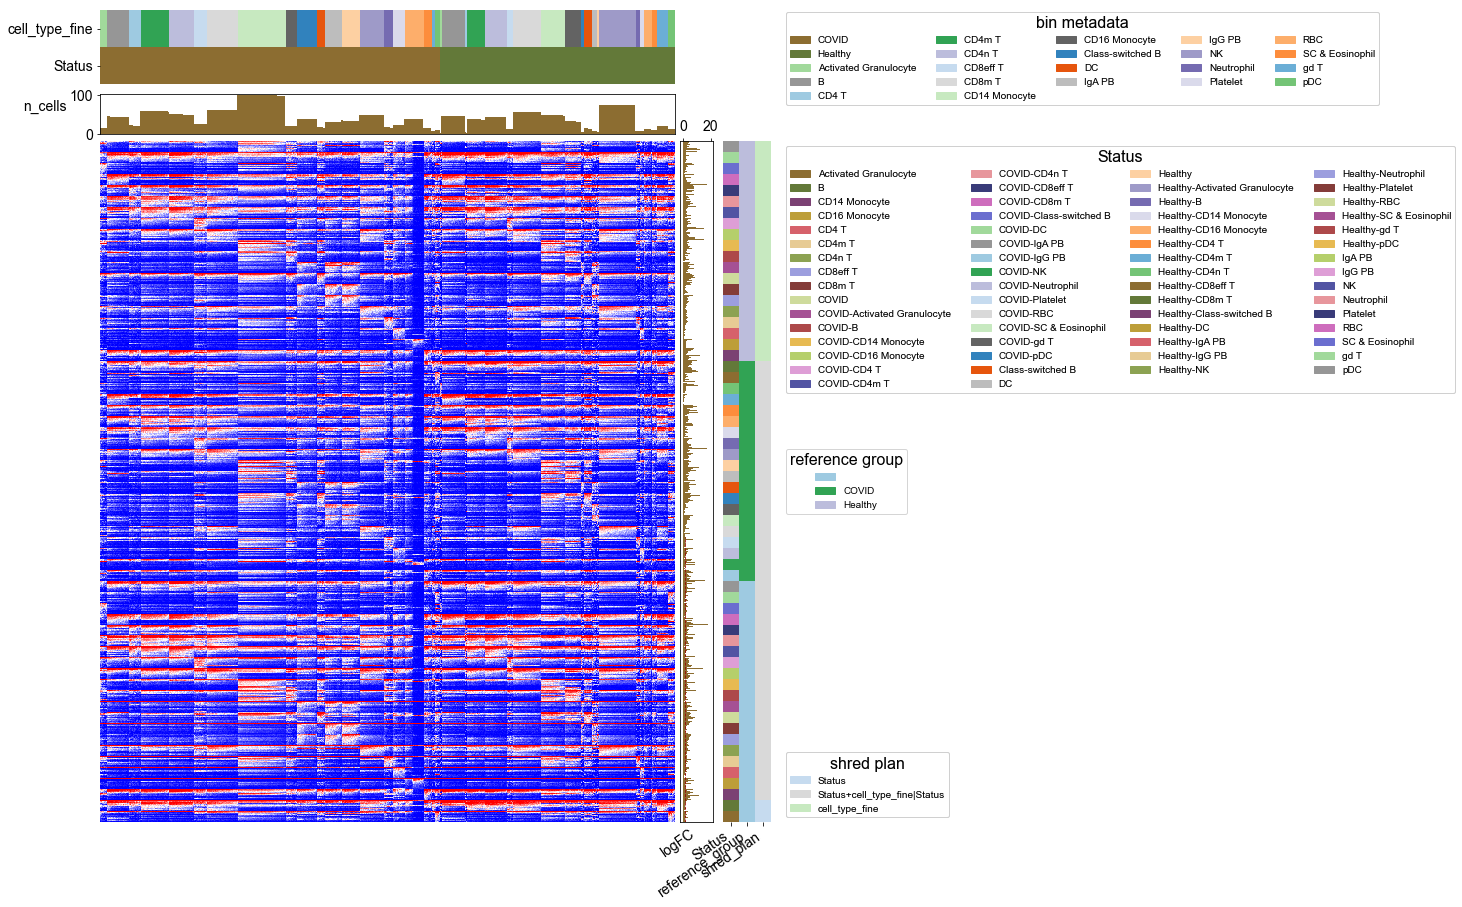

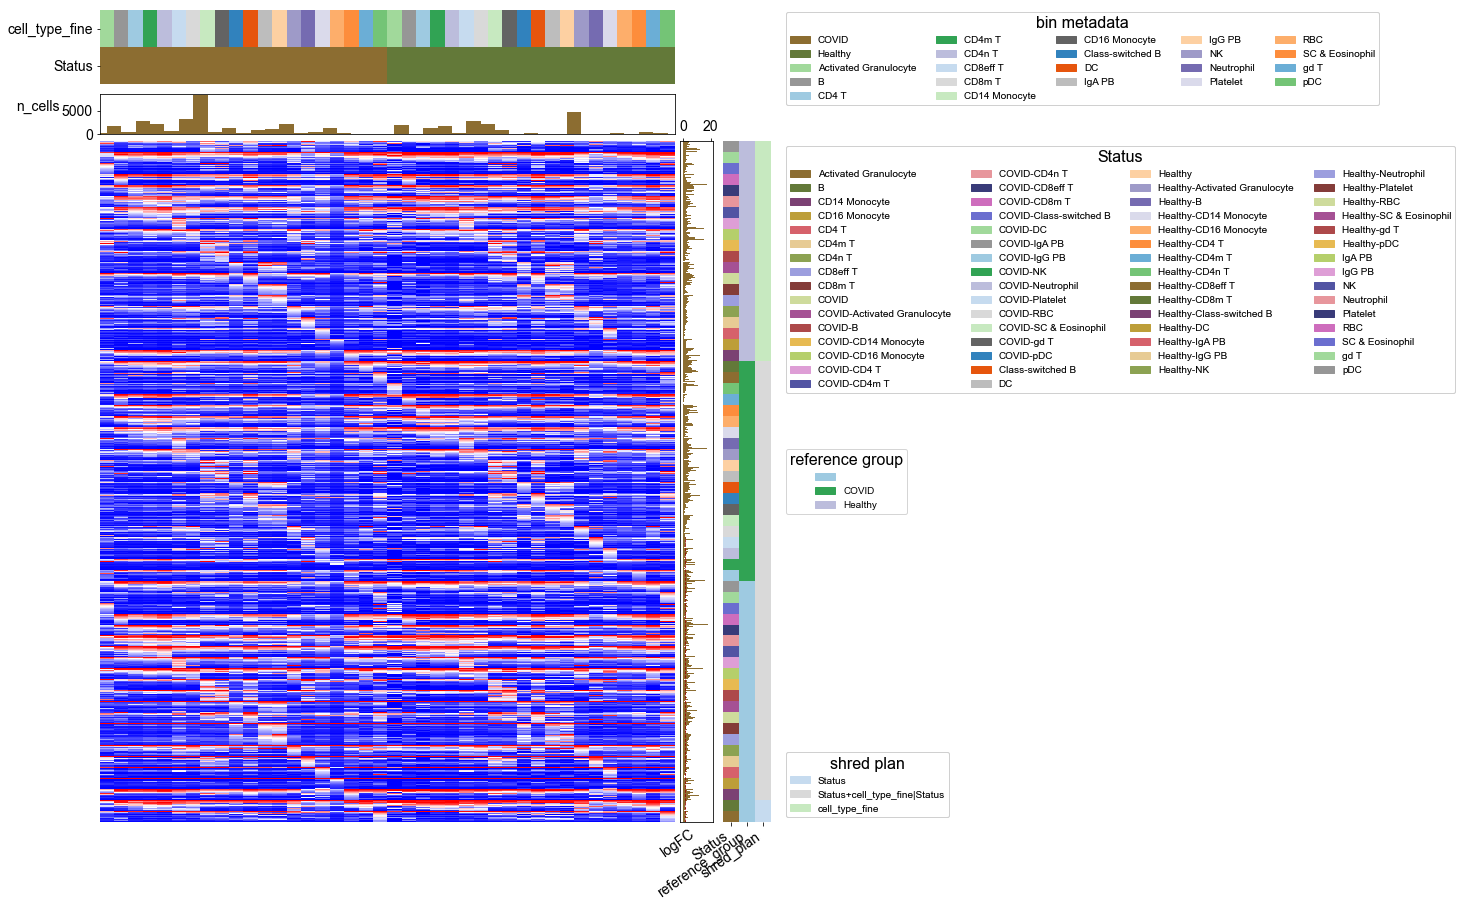

In [11]:
# draw heatmap for these gene modules. Both normal view and superbin view are generated
shred.draw_heatmap()

### 4. gene module enrichment

Gene module enrichment using [ToppGene enrichment](https://toppgene.cchmc.org/). Currently five categories of enrichment are included: GeneOntologyBiologicalProcess, GeneOntologyCellularComponent, GeneOntologyMolecularFunction, MousePheno, Pathway. 

In [12]:
shred.enrich_modules(categories = ["GeneOntologyCellularComponent"])

Create multiple gene set enrichment from enrichment results of all gene modules. The strategy is inspired by [ToppCluster](https://toppcluster.cchmc.org/).

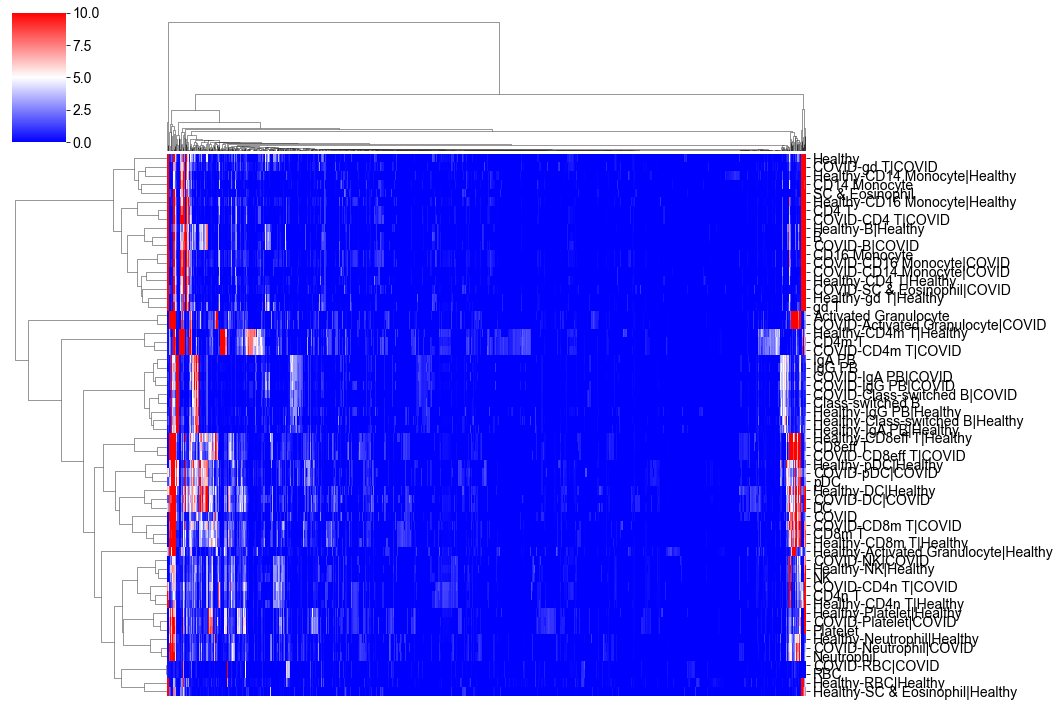

In [13]:
shred.toppcluster()

### 5. Create Morpheus input

Create a [Morpheus](https://software.broadinstitute.org/morpheus/) input file in GCT3-format.
Morpheus is a online interactive platform developped by Broad Institute, which is designed for flexible heatmap exploration.

In [14]:
shred.createGCT()

A view of GCT file in Morpheus.

![Morpheus](Morpheus-GCT3.pdf)

### 6. All code in one run

All steps above, including differential analysis, heatmap generation, gene module enrichment, ToppCluster view and GCT file generation, can be run in one code after initialization of shred object.

In [ ]:
# create shred object
shred = tp.Shred(adata = adata,
                shred_plan = ["Status", "cell_type_fine", "Status+cell_type_fine|Status"],
                bin_group = ["Status", "cell_type_fine"],
                order_bins = None,
                order_modules = None,
                method = "wilcoxon",
                output_dir = output_dir)

In [ ]:
# run all steps above in one row of code after initialization of shred object
shred.toppcell_batchRun()

### 7. Output file overview

In [1]:
import os
files = os.listdir("/Users/jinmr2/Dropbox/Code/data/toppcell_test/output_2021-10-05 00:46:31.793638")
files.sort(); files

['bin_matrix.txt',
 'bin_metadata.txt',
 'enrichment.txt',
 'enrichment_toppcluster.txt',
 'figures',
 'genemodules_all.txt',
 'genemodules_heatmap.txt',
 'heatmap_matrix.txt',
 'heatmap_matrix_GCT.gct',
 'heatmap_matrix_superbin.txt',
 'heatmap_matrix_superbin_GCT.gct',
 'superbin_matrix.txt',
 'superbin_metadata.txt']

##### Categories of output files

- (super) bin matrix and metadata:\
bin_matrix.txt\
bin_metadata.txt\
superbin_matrix.txt\
superbin_metadata.txt
- toppgene and toppcluster enrichment output:\
enrichment.txt\
enrichment_toppcluster.txt
- figures including gene module heatmap and toppcluster view:\
figures
- all gene modules:\
genemodules_all.txt
- heatmap in txt and gct format:\
genemodules_heatmap.txt\
heatmap_matrix.txt\
heatmap_matrix_GCT.gct\
heatmap_matrix_superbin.txt\
heatmap_matrix_superbin_GCT.gct